Solving the equation : Darcy Flow

\begin{equation}

 -\frac{d}{dx}\left( K(x) \frac{dP}{dx} \right) = f(x) \tag{1}
\end{equation}

The boundary conditons are :
\begin{equation}
  p \left( x = 0 \right) = 1,  p \left( x = 1 \right) = 0 \tag{2}
\end{equation}

Here, $f(x)=0$.

We use the central difference method:
\begin{equation}
 \frac{K_{i+\frac{1}{2}}(P_{i+1} - P_i) - K_{i-\frac{1}{2}}(P_i - P_{i-1})}{\Delta x^2} = 0 \tag{3}
\end{equation}
where
\begin{equation}
 K_{i+\frac{1}{2}} \approx \frac{K_i + K_{i+1}}{2} \tag{4}
\end{equation}

\begin{equation}
 K_{i-\frac{1}{2}} \approx \frac{K_i + K_{i-1}}{2}  \tag{5}
\end{equation}

In [13]:
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt

# Define the function to solve tan(w) = 2λw / (λ^2 w^2 - 1)
def equation_to_solve(w, lam):
    return np.tan(w) - 2 * lam * w / (lam**2 * w**2 - 1)

# A reasonable starting guess for w_n solutions could be around the zeros of the tan function, which are at (n+0.5)*pi
# We will use lambda = 1 (for example) and find the first few solutions
lambda_value = 1
solutions = []
number_of_solutions = 100

# We'll start the initial guesses just above the zero points of the tangent function to avoid division by zero
initial_guesses = [(n + 0.5) * np.pi for n in range(number_of_solutions)]

# Using fsolve to find the solutions
for guess in initial_guesses:
    wn_solution = fsolve(equation_to_solve, guess, args=(lambda_value))
    # We only append the solution if it is not already in the list (to avoid duplicates due to numerical precision)
    if not any(np.isclose(wn_solution, sol) for sol in solutions):
        solutions.append(wn_solution[0])

number_of_solutions = len(solutions)

In [14]:
# Function to calculate theta_n
def theta_n_1D(w_n, lam):
    return 2 * lam / ((lam**2)*(w_n**2) + 1) 

# Function to calculate b_n(x)
def b_n_1D(w_n, lam, x): 
    A_n =np.sqrt((np.sin(w_n * x))**2 + (lam*w_n*np.cos(w_n * x))**2)
    return  (np.sin(w_n * x) + lam * w_n * np.cos(w_n * x)) / A_n

# Calculate theta_n and b_n for a range of x values
# Choose an arbitrary range for x, for example, 0 to 2*pi with 100 points
mesh_size = 100
x_values = np.linspace(0, 1, mesh_size)
# Calculate theta_n for each solution w
theta_values_1D = np.array([theta_n_1D(w, lambda_value) for w in solutions])

# Calculate b_n for each combination of w_n and x_values
b_values_1D = np.array([[b_n_1D(w, lambda_value, x) for x in x_values] for w in solutions])

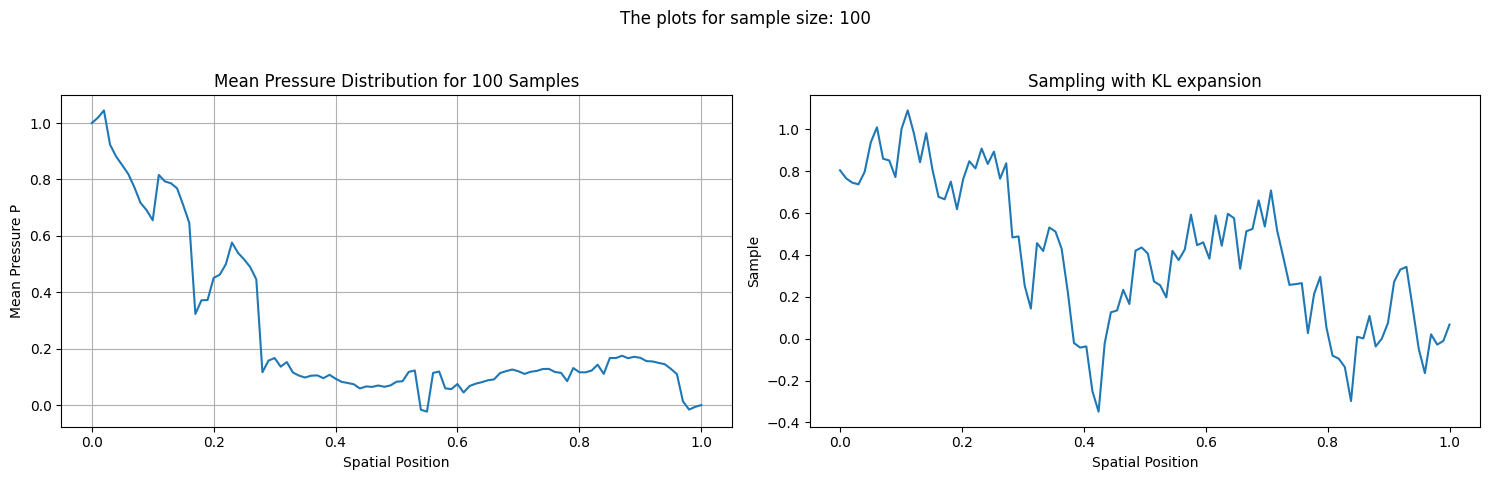

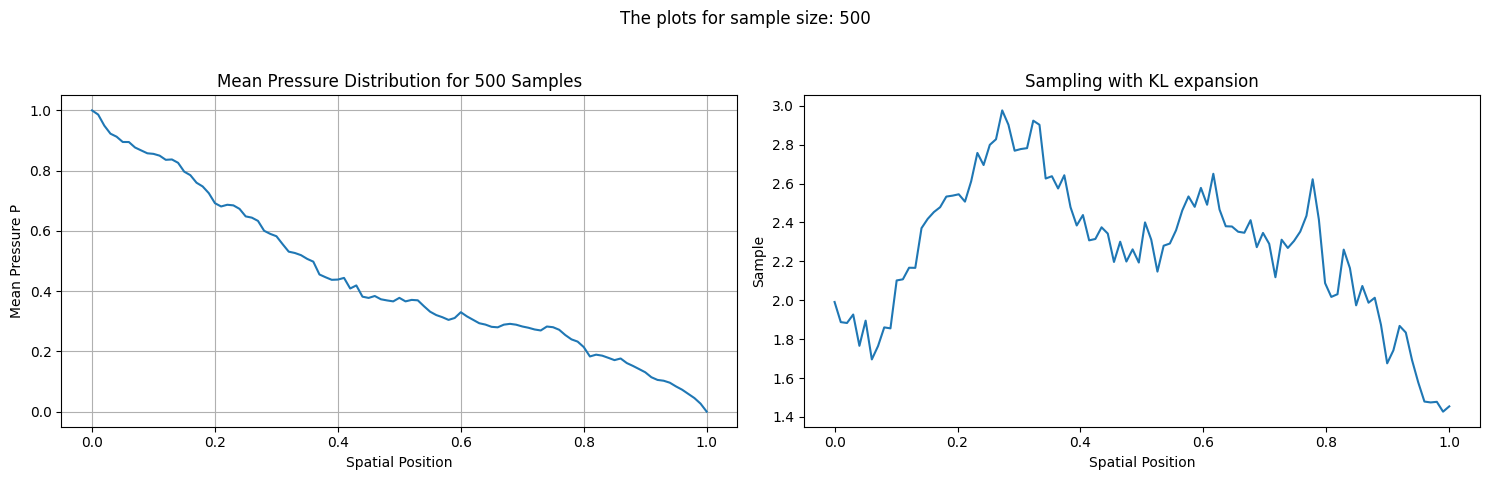

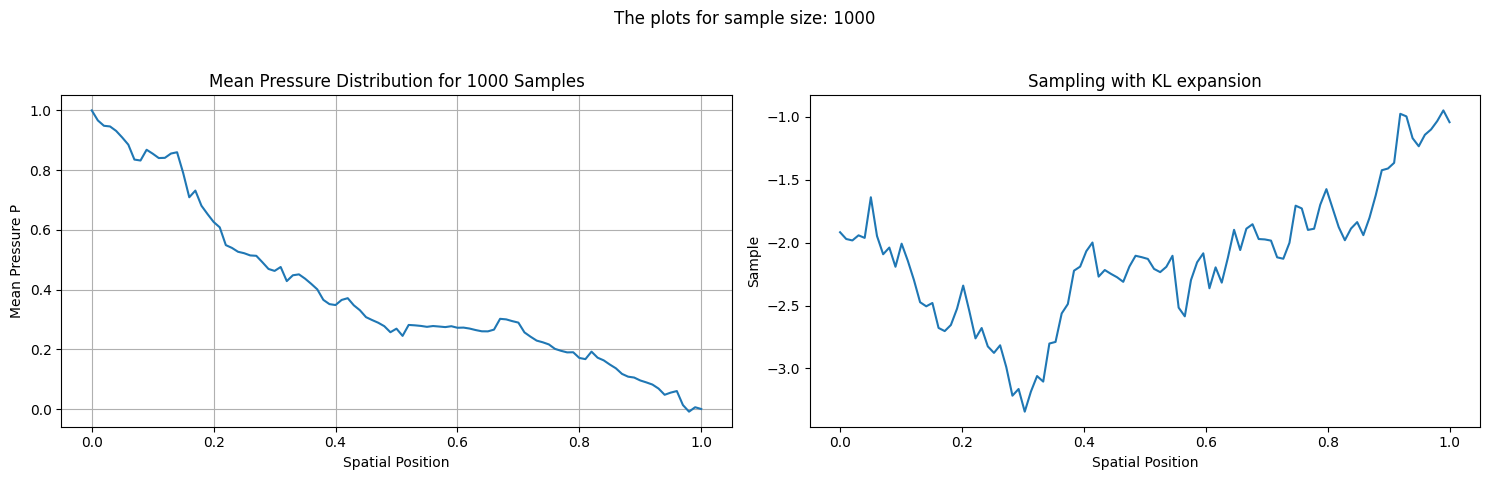

In [15]:
# Define the function to solve equation
def solve_darcy_flow(K):
    N = len(K) + 1  # The number of x-dimension grid divisions
    
    # Construct the matrix A
    A = np.zeros((N, N))
    b = np.zeros(N)
    
    # The initial condition
    A[0, 0] = A[-1, -1] = 1
    
    for i in range(1, N-1):
        if i == N-2:  
            K_avg_left = (K[i] + K[i-1]) / 2
            K_avg_right = K[i]  
        else:
            K_avg_left = (K[i-1] + K[i]) / 2
            K_avg_right = (K[i] + K[i+1]) / 2
        
        A[i, i-1] = K_avg_left
        A[i, i] = -(K_avg_left + K_avg_right)
        A[i, i+1] = K_avg_right
    
    
    # The boundary conditions
    b[0] = 1  # p(0) = 1
    b[-1] = 0  # p(1) = 0
    
    # Solve the equation
    P = np.linalg.solve(A, b)
    return P


# Generate P_samples
num_samples = 1000  # The number of sample for P is the same as for K
N = mesh_size+1
mean = 0
n_list = np.arange(0,number_of_solutions)
sample_sizes = [100, 500, 1000]
for num_samples in sample_sizes: 
    
    # Generate the K_samples 
    K_samples = np.zeros((num_samples, mesh_size))
 
    for i in range(num_samples):
        xi_n = np.random.normal(size=number_of_solutions)  # The xi_n for each sample
        Z = mean + np.dot((xi_n * np.sqrt(theta_values_1D)).T, b_values_1D)  # Generate a sample
        K_samples[i, :] = Z  # Store each sample into K_samples


    
    P_samples = np.zeros((num_samples, N))  # Initialise the P_samples with len(K_sample)+1 dimensions 

    for i in range(num_samples):
        # Solve the Darcy-Flow to generate the random samples: P_samples
        K_sample = K_samples[i,:]
        P_samples[i, :] = solve_darcy_flow(K_sample)

    # Calculat the mean of P_samples
    P_mean = np.mean(P_samples, axis=0)

    # Setup for the plots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # First subplot
    # Assuming theta_values_1D and n_list are defined somewhere in your code
    # Assuming P_mean is the mean pressure distribution calculated earlier
    ax[0].plot(np.linspace(0, 1, N), P_mean)
    ax[0].set_xlabel('Spatial Position')
    ax[0].set_ylabel('Mean Pressure P')
    ax[0].set_title(f'Mean Pressure Distribution for {num_samples} Samples')
    ax[0].grid(True)

    # Second subplot
    # Assuming Z and x_values are defined somewhere in your code
    ax[1].plot(x_values,Z)
    ax[1].set_xlabel(f'Spatial Position')
    ax[1].set_ylabel('Sample')
    ax[1].set_title('Sampling with KL expansion')

    # Show plot with a title indicating the sample size
    plt.suptitle(f'The plots for sample size: {num_samples}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make space for the suptitle
    plt.show()
